In [2]:
"""
# Tumor(Breast) Image Classification Using CNN
"""
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
"""
# Download image set from kaggle.
"""
! kaggle datasets download -d vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer

 97% 545M/564M [00:05<00:00, 89.1MB/s]
100% 564M/564M [00:05<00:00, 102MB/s] 


In [4]:
"""
# unzip data
"""
import zipfile
zf = "/content/ultrasound-breast-images-for-breast-cancer.zip"
target_dir = "/content/dataset/cnn/breast_cancer"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/dataset/cnn/breast_cancer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
"""
# Data Import
# Import basic libraries
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import pathlib

In [7]:
"""
# Path and class names
"""

train_path= '/content/dataset/cnn/breast_cancer/ultrasound breast classification/train'
#train_dir = pathlib.Path(train_path)
#print(train_dir)
test_path='/content/dataset/cnn/breast_cancer/ultrasound breast classification/val'
"""
class_names = np.array([item.name for item in train_dir.glob("*")])
class_names

"""
# Image count
"""

benignPath = pathlib.Path(os.path.join(train_dir,'benign'))
malignantPath = pathlib.Path(os.path.join(train_dir,'malignant'))

benignImageCount = len(list(train_dir.glob('*.png')))
malignantImageCount = len(list(train_dir.glob('*.png')))

totalImageCount = benignImageCount + malignantImageCount

print("Total Images: ", totalImageCount)
print("Benign (non-dangerous) Images: {}({})".format(benignImageCount, round(benignImageCount*100/totalImageCount, 2)))
print("Malignant (dangerous) Images: {}({})".format(malignantImageCount, round(malignantImageCount*100/totalImageCount, 2)))
"""

'\n\nbenignPath = pathlib.Path(os.path.join(train_dir,\'benign\'))\nmalignantPath = pathlib.Path(os.path.join(train_dir,\'malignant\'))\n\nbenignImageCount = len(list(train_dir.glob(\'*.png\')))\nmalignantImageCount = len(list(train_dir.glob(\'*.png\')))\n\ntotalImageCount = benignImageCount + malignantImageCount\n\nprint("Total Images: ", totalImageCount)\nprint("Benign (non-dangerous) Images: {}({})".format(benignImageCount, round(benignImageCount*100/totalImageCount, 2)))\nprint("Malignant (dangerous) Images: {}({})".format(malignantImageCount, round(malignantImageCount*100/totalImageCount, 2)))\n'

In [8]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 8116 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [10]:
"""
# Define Model
# Rescale images add a Dropout to avoid the overfitting
# sigmoid as activation for dense layer, Relu for conv layers
# 7 layer CNN Model Architecture with 3 Convolution layer each followed by max pooling layer
# Filter size =3X3 and Activation function = Relu
"""

base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1536)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                           

In [13]:
"""
# Compile and fit the Model
"""

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=5,monitor='val_loss')

filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,es]
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator,
    steps_per_epoch= 50
    #,
    #callbacks=callbacks_list, 
    #verbose=0
    )

Epoch 1/6
50/50 [==============================] - 176s 3s/step - loss: 0.6165 - accuracy: 0.7250 - auc: 0.7874 - precision: 0.7053 - recall: 0.7128 - val_loss: 0.4296 - val_accuracy: 0.8189 - val_auc: 0.8950 - val_precision: 0.8516 - val_recall: 0.7175
Epoch 2/6
50/50 [==============================] - 107s 2s/step - loss: 0.5936 - accuracy: 0.7450 - auc: 0.8161 - precision: 0.6979 - recall: 0.7528 - val_loss: 0.4402 - val_accuracy: 0.8189 - val_auc: 0.8826 - val_precision: 0.8000 - val_recall: 0.7900
Epoch 3/6
50/50 [==============================] - 107s 2s/step - loss: 0.4536 - accuracy: 0.7700 - auc: 0.8680 - precision: 0.7640 - recall: 0.7312 - val_loss: 0.4546 - val_accuracy: 0.8256 - val_auc: 0.8912 - val_precision: 0.8076 - val_recall: 0.7975
Epoch 4/6
50/50 [==============================] - 107s 2s/step - loss: 0.5309 - accuracy: 0.7550 - auc: 0.8497 - precision: 0.7826 - recall: 0.7129 - val_loss: 0.4367 - val_accuracy: 0.8156 - val_auc: 0.9112 - val_precision: 0.8750 - val

In [14]:
model.evaluate(validation_generator)
model.evaluate(train_generator)

2029/2029 [==============================] - 819s 403ms/step - loss: 0.4298 - accuracy: 0.8094 - auc: 0.8931 - precision: 0.8011 - recall: 0.8211


[0.42975562810897827,
 0.8093888759613037,
 0.8930829763412476,
 0.8011103272438049,
 0.8211281299591064]

1/1 [==============================] - 3s 3s/step
[[0.00045571]]
THE UPLOADED IMAGE IS SUSPECTED AS: Benign


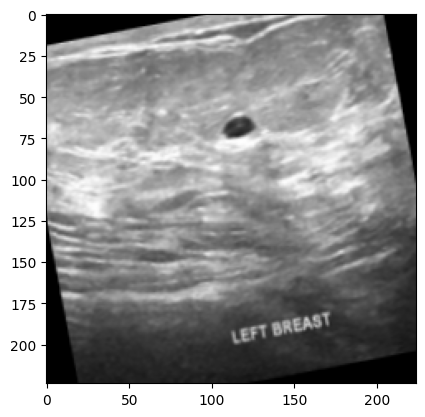

In [15]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/content/dataset/cnn/breast_cancer/ultrasound breast classification/val/benign/benign (1)-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Benign"   
else:
      op="Malignant"
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))

In [16]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [17]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [18]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

44334584

In [19]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_efficientnetb3_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 783, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = 'model.tflite'
interpreter1 = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter1.allocate_tensors()

input_index = interpreter1.get_input_details()[0]["index"]
output_index = interpreter1.get_output_details()[0]["index"]

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
img = load_img('/content/dataset/cnn/breast_cancer/ultrasound breast classification/val/benign/benign (1)-rotated1-rotated1.png',target_size=(224,224))


test_labels, test_imgs = [], []
for img, label in tqdm(train_generator):
    interpreter1.set_tensor(input_index, img)
    interpreter1.invoke()
    predictions.append(interpreter1.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")